In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
# from numpy.fft import fftshift, ifft2

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [3]:
# === 模拟 RCWA 输出：r_mn ===
# 假设我们使用 2D RCWA，得到一个 NxN 的衍射谱
N = 21  # 表示从 -10 到 +10 阶，共21阶
M = N // 2
Lambda_x = 400e-9  # 光栅x周期 (m)
Lambda_y = 400e-9  # 光栅y周期 (m)


In [4]:
# 随机生成 r_mn 作为模拟 RCWA 输出（真实仿真中应由 RCWA 提供）
np.random.seed(0)
r_mn = 0.5 * (np.random.rand(N, N) + 1j * np.random.rand(N, N))

In [5]:
# === 空间网格设置 ===
Nx = 256  # real space 解析度
Ny = 256
Lx = 2e-6  # 空间范围2μm
Ly = 2e-6

x = np.linspace(-Lx/2, Lx/2, Nx)
y = np.linspace(-Ly/2, Ly/2, Ny)
X, Y = np.meshgrid(x, y)

In [6]:
# === 合成 real space 场 E(x,y) ===
E_xy = np.zeros((Ny, Nx), dtype=complex)

for m in range(-M, M+1):
    for n in range(-M, M+1):
        fx = m / Lambda_x
        fy = n / Lambda_y
        idx_m = m + M
        idx_n = n + M
        E_xy += r_mn[idx_n, idx_m] * np.exp(1j * 2 * np.pi * (fx * X + fy * Y))

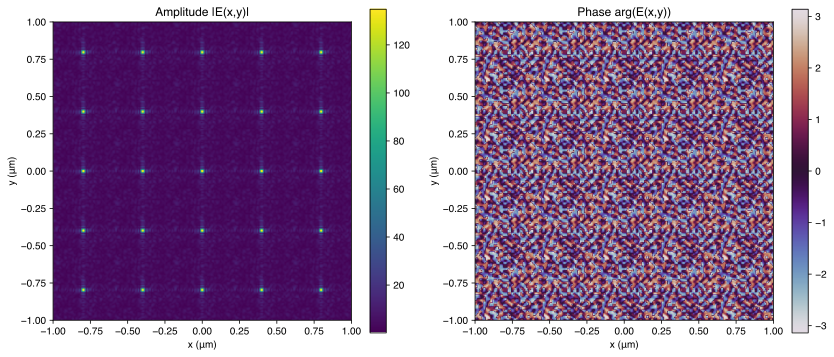

In [7]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.abs(E_xy), extent=[-Lx/2*1e6, Lx/2*1e6, -Ly/2*1e6, Ly/2*1e6], cmap='viridis')
plt.title('Amplitude |E(x,y)|')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.angle(E_xy), extent=[-Lx/2*1e6, Lx/2*1e6, -Ly/2*1e6, Ly/2*1e6], cmap='twilight')
plt.title('Phase arg(E(x,y))')
plt.xlabel('x (μm)')
plt.ylabel('y (μm)')
plt.colorbar()

plt.tight_layout()
plt.show()
